# Zillow Prize

The objective of this competition is to estimate something called the **_logerror_**, which is the log of the ratio of the Zillow Zestimate of the sell price of a house and the actual sale price. We won't be given the actual Zestimate or price. The point is to figure out what sorts of sales Zillow is good at estimating, and what sort they are bad at estimating.

## Setup
Import useful packages for data analysis and plotting.

In [41]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context = 'notebook', font_scale = 1.5, rc={'figure.figsize':(10, 6)})

from IPython.display import display #for displaying multiple outputs from a single cell

import datetime

#import xgboost as xgb

#import sklearn
#import sklearn.neural_network
#import sklearn.model_selection
#import sklearn.decomposition

## Import Data

Import the training data.

In [2]:
train_data = pd.read_csv('train_2016.csv')
train_data.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [47]:
prop_data = pd.read_csv('properties_2016.csv')

/Users/stefan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
train_data.transactiondate=train_data.transactiondate.apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))

In [35]:
train_data['day'] =train_data['transactiondate']-datetime.datetime.strptime('2016-01-01','%Y-%m-%d')

In [57]:
train_data['day'] = train_data['day'].apply(lambda x: x.days)

In [86]:
train_data['month'] =train_data['transactiondate'].apply(lambda x: x.month)
train_data.head()

,parcelid,logerror,transactiondate,day,month
0,11016594,0.0276,2016-01-01,0,1
1,14366692,-0.1684,2016-01-01,0,1
2,12098116,-0.0040,2016-01-01,0,1
3,12643413,0.0218,2016-01-02,1,1
4,14432541,-0.0050,2016-01-02,1,1


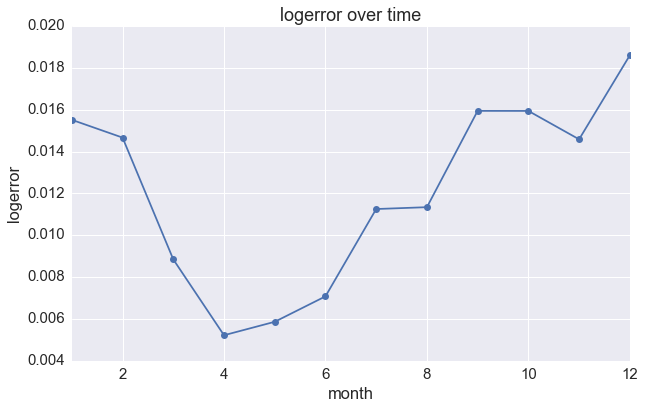

In [118]:
train_data[['logerror','month']].groupby('month').mean().plot(marker='o', legend=False)
plt.title('logerror over time')
plt.ylabel('logerror')
plt.show()

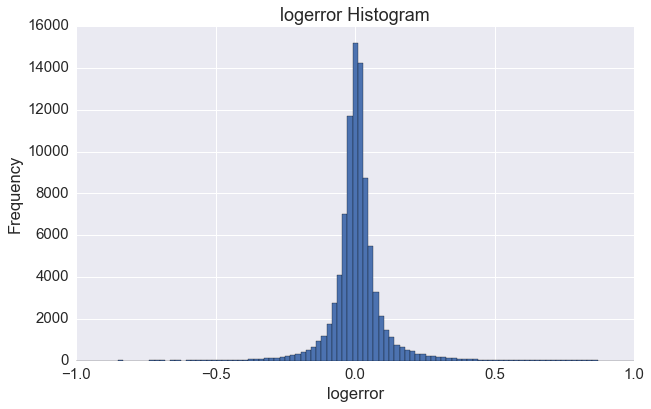

In [80]:
train_data.hist('logerror',bins=500)

#Change the labels of the axes and title
plt.title('logerror Histogram')
plt.xlabel('logerror')
plt.ylabel('Frequency')
plt.axis([-1,1,0,16000])

#Explicitly entering the show command gives cleaner output.
plt.show()

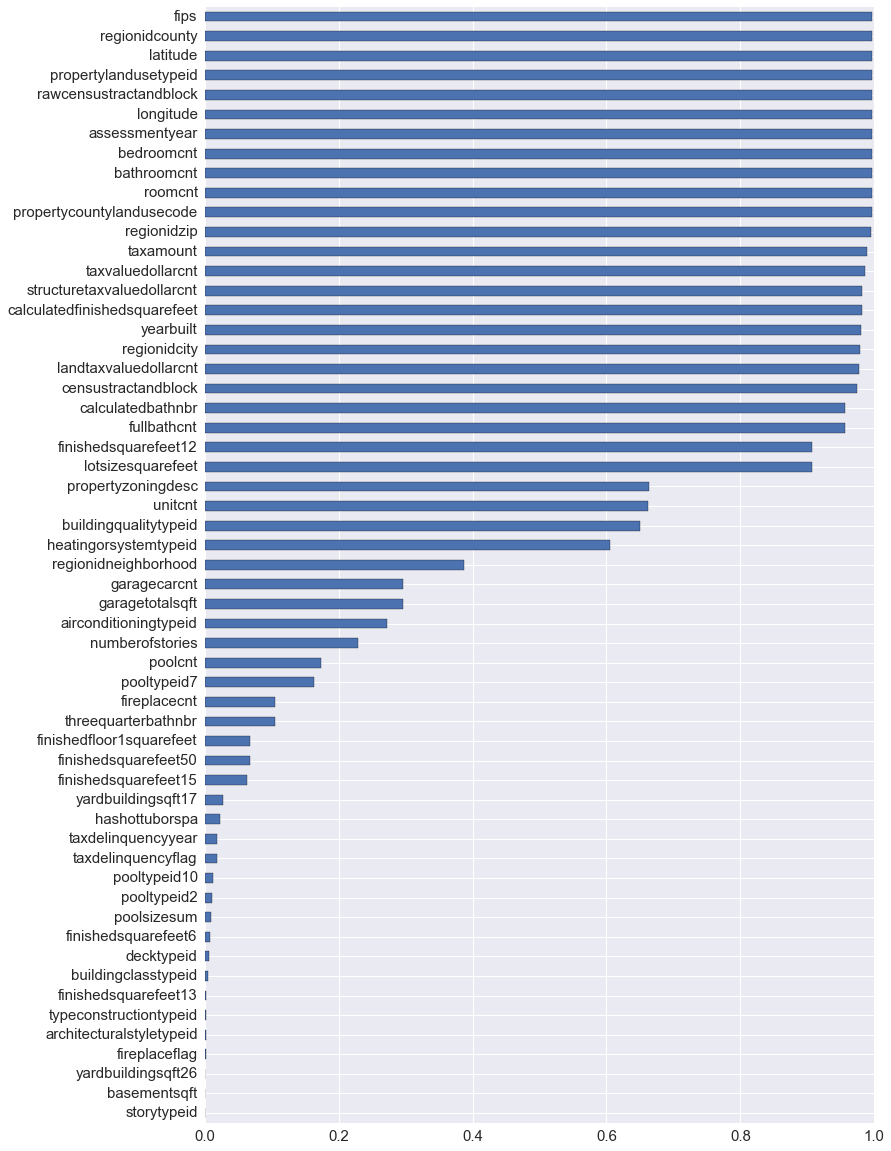

storytypeid                     0.000544
basementsqft                    0.000545
yardbuildingsqft26              0.000887
fireplaceflag                   0.001730
architecturalstyletypeid        0.002030
typeconstructiontypeid          0.002260
finishedsquarefeet13            0.002570
buildingclasstypeid             0.004231
decktypeid                      0.005727
finishedsquarefeet6             0.007370
poolsizesum                     0.009366
pooltypeid2                     0.010745
pooltypeid10                    0.012374
taxdelinquencyflag              0.018914
taxdelinquencyyear              0.018915
hashottuborspa                  0.023119
yardbuildingsqft17              0.026918
finishedsquarefeet15            0.063914
finishedsquarefeet50            0.067907
finishedfloor1squarefeet        0.067907
threequarterbathnbr             0.104391
fireplacecnt                    0.104728
pooltypeid7                     0.162621
poolcnt                         0.173366
numberofstories 

In [48]:
with plt.rc_context({"figure.figsize": [12,20]}):
    prop_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True).plot(kind = 'barh')
plt.show()
prop_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True)

In [57]:
train_data.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [60]:
merged = train_data.merge(prop_data, how = 'left')

In [64]:
merged.notnull().mean().sort_values()

buildingclasstypeid             0.000176
finishedsquarefeet13            0.000363
storytypeid                     0.000474
basementsqft                    0.000474
yardbuildingsqft26              0.001046
fireplaceflag                   0.002445
architecturalstyletypeid        0.002874
typeconstructiontypeid          0.003293
finishedsquarefeet6             0.004636
decktypeid                      0.007246
poolsizesum                     0.010671
pooltypeid10                    0.012785
pooltypeid2                     0.013258
taxdelinquencyflag              0.019634
taxdelinquencyyear              0.019634
hashottuborspa                  0.026043
yardbuildingsqft17              0.029137
finishedsquarefeet15            0.039246
finishedfloor1squarefeet        0.075497
finishedsquarefeet50            0.075497
fireplacecnt                    0.105791
threequarterbathnbr             0.132242
pooltypeid7                     0.183865
poolcnt                         0.197124
numberofstories 